# Homework 3 - data transformation & dimensionality reduction (deadline 18. 12. 2022, 23:59)

In short, the main task is to play with transformations and dimensionality reduction to obtain the best results for the linear regression model predicting house sale prices.
  
> The instructions are not given in detail: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can!

However, we **strongly recommend and require** the following:
* Follow the assignment step by step. Number each step.
* Properly comment all your steps. Comments are evaluated for 2 points of the total together with the final presentation of the solution. However, it is not desirable to write novels! 
* Do not leave the task to the last minute.
* Hand in a notebook that has already been run (i.e. do not delete outputs before handing in).

## What are you supposed to do:

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (= our prediction model) of the observed sale prices.

**Just copied code from tutorial 3 and 5 will not be accepted.**

### Instructions:

  1. Download the dataset from the [course pages](https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html) (data.csv, data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques). 
  1. Transform features appropriately and prepare new ones - focus on the increase in the performance of the model (possibly in combination with further steps). Split the dataset into a train and test part exactly as we did in the tutorials. Use the test part for evaluation of the influence of further steps. _(3 points)_
  1. Try to find some suitable subset of features - first without the use of PCA. _(4 points)_
  1. Use PCA (principal component analysis) to reduce the dimensionality. Discuss the influence of the number of principal components. _(4 points)_
  1. Compare the results of previous steps on the test part of the dataset. _(3 points)_
  
Give comments (!) on each step of your solution, with short explanations of your choices.

All your steps and following code **have to be commented!** Comments are evaluated for _2 points_ together with the final presentation of the solution.

**If you do all this properly, you will obtain 16 points.**

**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the technical instructions from https://courses.fit.cvut.cz/NI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, she can (!) give you another chance to rework your homework and to obtain more points. However, this is not a given, so do your best! :)
  * English is not compulsory.

In [2]:
from typing import Literal
import itertools
from collections import Counter

import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection
from sklearn.metrics import mean_squared_log_error, make_scorer, mean_squared_error, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA

from imblearn.under_sampling import TomekLinks, NeighbourhoodCleaningRule
from imblearn.combine import SMOTETomek


import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=fac46d80-8851-4bae-bf0f-d9911201e26f' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>

### 1. Download/Load data

In [3]:
RANDOM_STATE = 42

In [4]:
df = pd.read_csv('data.csv')
display(df.head())
df.shape

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


(1460, 81)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [6]:
df.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [7]:
df.nunique()

Id               1460
MSSubClass         15
MSZoning            5
LotFrontage       110
LotArea          1073
                 ... 
MoSold             12
YrSold              5
SaleType            9
SaleCondition       6
SalePrice         663
Length: 81, dtype: int64

In [8]:
# define helper functions for linear and ridge regression
def linreg(train, validate, plot = True, train_error = True) -> float:
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice

    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y)

    # Print RMSLE
    # print(f'Linear regression root mean squared log validation error: {np.sqrt(metrics.mean_squared_error(clf.predict(Xv),yv)):.0f}')
    lin_reg_val_err = np.sqrt(metrics.mean_squared_log_error(clf.predict(Xv),yv))
    print(f'Linear regression root mean squared log validation error: {lin_reg_val_err}')
    if train_error:
        # print(f'Linear regression root mean squared log train error: {np.sqrt(metrics.mean_squared_error(clf.predict(X), y)):.0f}')
        print(f'Linear regression root mean squared log train error: {np.sqrt(metrics.mean_squared_log_error(clf.predict(X), y))}')

    # Plot
    if plot:
        plt.scatter(yv, clf.predict(Xv))
        plt.plot([0,600000], [0,600000], 'r')
        plt.show()

    return lin_reg_val_err

def ridgereg(train, validate, plot = True, train_error = True, print_opt = False):
    # Prepare functions to automatic alpha determination using cross validation
    def scorer(Y, yp):
        # return np.sqrt(metrics.mean_squared_error(Y, yp)) # RMSE as scorer
        return np.sqrt(metrics.mean_squared_log_error(Y, yp)) # RMSLE as scorer
    def ridgemodel(alpha): # looks for optimal alpha (regularization parameter)
        clf = linear_model.Ridge(alpha=alpha)
        return np.mean(model_selection.cross_val_score(clf, X, y, cv=5, scoring=metrics.make_scorer(scorer)))

    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice

    # Find Ridge alpha automatically
    opt_alpha = optimize.minimize_scalar(ridgemodel, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    if print_opt:
        print(opt_alpha)

    # Ridge regression model
    clf = linear_model.Ridge(alpha=opt_alpha.x) # better solution: use validation data
    clf.fit(X, y)

    # Print RMSLE
    # print(f'Ridge regression root mean squared log validation error: {np.sqrt(metrics.mean_squared_error(clf.predict(Xv),yv)):.0f}')
    print(f'Ridge regression root mean squared log validation error: {np.sqrt(metrics.mean_squared_log_error(clf.predict(Xv),yv))}')
    if train_error:
        # print(f'Ridge regression root mean squared log train error: {np.sqrt(metrics.mean_squared_error(clf.predict(X), y)):.0f}')
        print(f'Ridge regression root mean squared log train error: {np.sqrt(metrics.mean_squared_log_error(clf.predict(X), y))}')
    # Plot
    if plot:
        plt.scatter(yv, clf.predict(Xv))
        plt.plot([0,600000], [0,600000], 'r')
        plt.show()

### 2. Transform features appropriately and prepare new ones - focus on the increase in the performance of the model (possibly in combination with further steps). Split the dataset into a train and test part exactly as we did in the tutorials. Use the test part for evaluation of the influence of further steps. _(3 points)_

In order to use linear regression, some of the features need to be transformed (objects, strings, ...)

In [9]:
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')

In [10]:
# # Convert all string values to categorial format
# df[df.select_dtypes(include=['string']).columns] = df.select_dtypes(include=['string']).apply(pd.Series.astype, dtype='category')


In [11]:
# Fill all numeric NaNs with 0 (regression does not accept NaNs)
# no missing data in type 'int64'
# df.loc[:,df.select_dtypes(include=['float64']).columns] = df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

There are some missing values, so lets try to use KNNImputer, which usually has quite good results, to input these

In [12]:
# # no missing values in `y`, so safe to apply to whole dataset
# imputer = KNNImputer(n_neighbors=2)
# # df = imputer.fit_transform(df)
# df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

Apply one hot encoding

In [13]:
df = pd.get_dummies(df)

Convert not 1-hot-encoded numerical values to floats

In [14]:
df[df.select_dtypes(['float64', 'int64']).columns] = df[df.select_dtypes(['float64', 'int64']).columns].astype('float64')

In [15]:
# no missing values in `y`, so safe to apply to whole dataset
imputer = KNNImputer(n_neighbors=2)
# df = imputer.fit_transform(df)
df = pd.DataFrame(imputer.fit_transform(df), columns = df.columns)

Split data into train and test sets

In [16]:
dt, dv = model_selection.train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dv = dv.copy()
print('Train: ', len(dt), '; Validation: ', len(dv))

Train:  1095 ; Validation:  365


Linear regression root mean squared log validation error: 0.1740346746817662
Linear regression root mean squared log train error: 0.10712481243643908


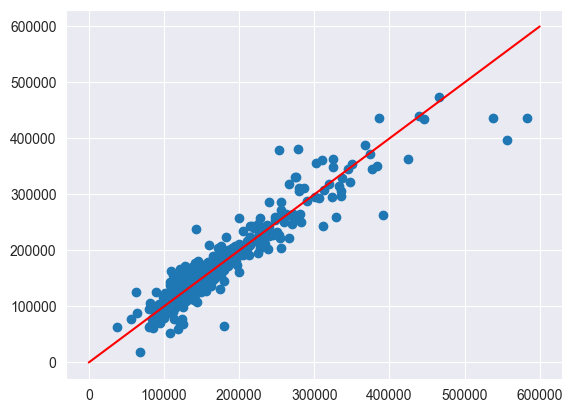

Ridge regression root mean squared log validation error: 0.13840261854450098
Ridge regression root mean squared log train error: 0.13224435412963875


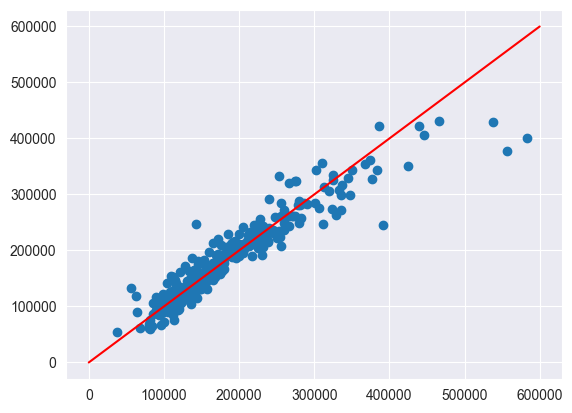

In [17]:
# Run both models
linreg(dt, dv)
print(20*"=")
ridgereg(dt, dv)

Let's try to apply minmax scaling

In [18]:
minmax_scaler = preprocessing.MinMaxScaler()

### 3. Try to find some suitable subset of features - first without the use of PCA. _(4 points)

In [19]:
# Remove constant features
dt = dt[df.columns[df.min() != df.max()]]
dv = dv[df.columns[df.min() != df.max()]]

Remove low variance features

In [20]:
selector = VarianceThreshold(threshold=0.01)
# fit on train data only !
selector.fit(dt)
dt = pd.DataFrame(selector.transform(dt), columns = selector.get_feature_names_out())
dv = pd.DataFrame(selector.transform(dv), columns = selector.get_feature_names_out())

Linear regression root mean squared log validation error: 0.15695150970406033
Linear regression root mean squared log train error: 0.1337923588015546


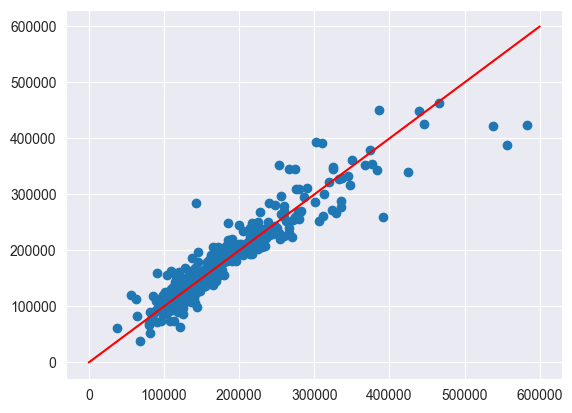

Ridge regression root mean squared log validation error: 0.13927555890046636
Ridge regression root mean squared log train error: 0.1347574386647274


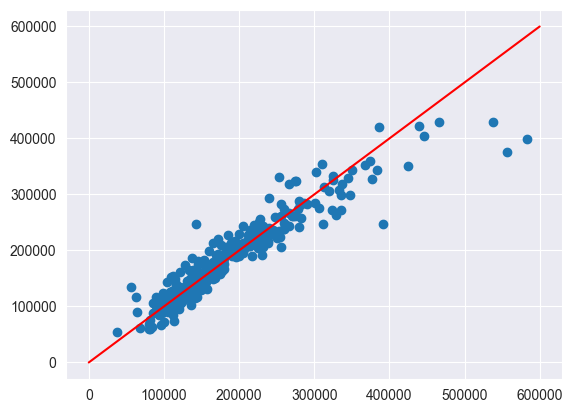

In [21]:
# Run both models
linreg(dt, dv)
print(20*"=")
ridgereg(dt, dv)

show deleted columns

In [22]:
set(df.columns) - set(dt.columns)

{'BsmtCond_Po',
 'BsmtFinType2_GLQ',
 'Condition1_PosA',
 'Condition1_RRAe',
 'Condition1_RRNe',
 'Condition1_RRNn',
 'Condition2_Artery',
 'Condition2_Feedr',
 'Condition2_PosA',
 'Condition2_PosN',
 'Condition2_RRAe',
 'Condition2_RRAn',
 'Condition2_RRNn',
 'Electrical_FuseP',
 'Electrical_Mix',
 'ExterCond_Ex',
 'ExterCond_Po',
 'ExterQual_Fa',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_CBlock',
 'Exterior1st_ImStucc',
 'Exterior1st_Stone',
 'Exterior2nd_AsphShn',
 'Exterior2nd_Brk Cmn',
 'Exterior2nd_CBlock',
 'Exterior2nd_ImStucc',
 'Exterior2nd_Other',
 'Exterior2nd_Stone',
 'Fence_MnWw',
 'Foundation_Stone',
 'Foundation_Wood',
 'Functional_Maj2',
 'Functional_Mod',
 'Functional_Sev',
 'GarageCond_Ex',
 'GarageCond_Gd',
 'GarageCond_Po',
 'GarageQual_Ex',
 'GarageQual_Gd',
 'GarageQual_Po',
 'GarageType_2Types',
 'GarageType_CarPort',
 'HeatingQC_Po',
 'Heating_Floor',
 'Heating_Grav',
 'Heating_OthW',
 'Heating_Wall',
 'HouseStyle_1.5Unf',
 'HouseStyle_2.5Fi

not lets try use delete features based on lowest correlation

In [23]:
# Correlation matrix Pearson & Spearman
corrP = dt.corr(method='pearson')
corrS = dt.corr(method='spearman')

<AxesSubplot: >

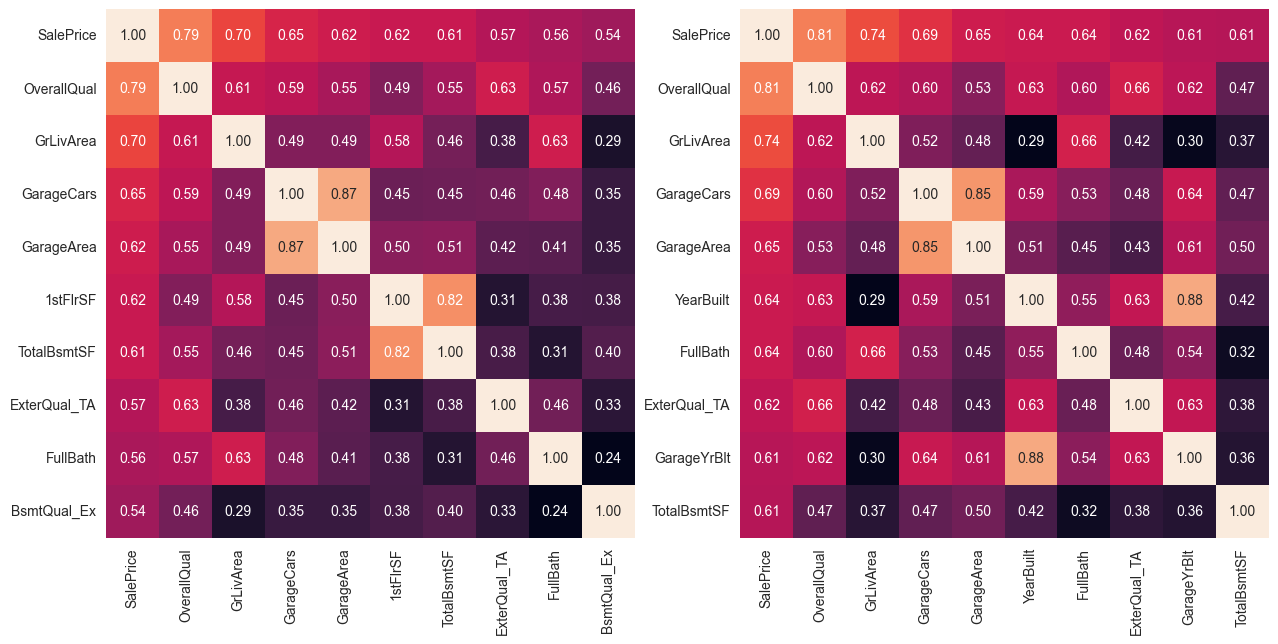

In [24]:
corrP_cols = corrP.SalePrice.abs().nlargest(10).index
corrS_cols = corrS.SalePrice.abs().nlargest(10).index

# Plot those correlations
fig, axs = plt.subplots(ncols=2, figsize=(15,7))
sns.heatmap(corrP.abs().loc[corrP_cols,corrP_cols],ax=axs[0], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrP_cols.values, xticklabels=corrP_cols.values)
sns.heatmap(corrS.abs().loc[corrS_cols,corrS_cols],ax=axs[1], cbar=False, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=corrS_cols.values, xticklabels=corrS_cols.values)

run linear regression with features deleted by lowest corelation with threshold between 0.001 and 0.096

In [25]:
list(dt.columns)

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice',
 'MSZoning_FV',
 'MSZoning_RH',
 'MSZoning_RL',
 'MSZoning_RM',
 'Alley_Grvl',
 'Alley_Pave',
 'LotShape_IR1',
 'LotShape_IR2',
 'LotShape_Reg',
 'LandContour_Bnk',
 'LandContour_HLS',
 'LandContour_Low',
 'LandContour_Lvl',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_FR2',
 'LotConfig_Inside',
 'LandSlope_Gtl',
 'LandSlope_Mod',
 'Neighborhood_Blmngtn',
 'Neighborhood_BrkSide',
 'Neighborhood_ClearCr',
 'Neighborhood_CollgCr',


In [26]:
threasholds = {}
for i in range(1, 100, 5):
    threshold = i * 0.001
    columns_to_remove = list(corrP.SalePrice[corrP.SalePrice.abs() < threshold].index)
    tmp_dt = dt.drop(columns=columns_to_remove)
    tmp_dv = dv.drop(columns=columns_to_remove)
    print(f"Threashold {threshold}, drop={columns_to_remove}")
    val_err = linreg(tmp_dt, tmp_dv, plot=False)
    threasholds[threshold] = val_err
    print(20*"=")


Threashold 0.001, drop=['BsmtFinSF2', 'BsmtHalfBath', 'Condition1_RRAn', 'Fence_GdPrv']
Linear regression root mean squared log validation error: 0.15516573103832237
Linear regression root mean squared log train error: 0.13399479996127656
Threashold 0.006, drop=['BsmtFinSF2', 'BsmtHalfBath', 'LandContour_Lvl', 'Condition1_RRAn', 'Fence_GdPrv']
Linear regression root mean squared log validation error: 0.15516573103832024
Linear regression root mean squared log train error: 0.13399479996125302
Threashold 0.011, drop=['BsmtFinSF2', 'BsmtHalfBath', 'LandContour_Lvl', 'LotConfig_FR2', 'Neighborhood_SawyerW', 'Condition1_RRAn', 'BldgType_TwnhsE', 'Fence_GdPrv']
Linear regression root mean squared log validation error: 0.15532742946670577
Linear regression root mean squared log train error: 0.1341207430412141
Threashold 0.016, drop=['BsmtFinSF2', 'BsmtHalfBath', 'LandContour_Lvl', 'LotConfig_FR2', 'Neighborhood_SawyerW', 'Condition1_RRAn', 'BldgType_TwnhsE', 'Heating_GasW', 'Fence_GdPrv']
Lin

find out the threshold with the best results

In [33]:
import operator
display(min(threasholds.items(), key=operator.itemgetter(1)))
best_threshold = min(threasholds.items(), key=operator.itemgetter(1))[0]

(0.056, 0.1458838832426851)

drop the columns from the actual dataframes

In [28]:
columns_to_remove = list(corrP.SalePrice[corrP.SalePrice.abs() < best_threshold].index)
dt = dt.drop(columns=columns_to_remove)
dv = dv.drop(columns=columns_to_remove)

### 4. Use PCA (principal component analysis) to reduce the dimensionality. Discuss the influence of the number of principal components. _(4 points)_

In [29]:
len(dt.columns)

161

Lets try to apply PCA with number of components from 1 up to 100

In [30]:
component_count = {}
for i in range(1, 100):
    pca = PCA(i)
    # tmp_dt = pca.transform(dt)
    dt_y = dt['SalePrice']
    dt_X = dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
    pca.fit(dt_X)
    tmp_dt = pd.DataFrame(pca.transform(dt_X), columns = pca.get_feature_names_out())
    # make negative values into positive ones (RMSLE cannot use negative values)
    tmp_dt[tmp_dt <= 0] = 1e-3
    tmp_dt['SalePrice'] = dt_y
    # tmp_dv = pca.transform(dv)
    dv_y = dv['SalePrice']
    dv_X = dv.drop(['SalePrice'], axis = 1, errors = 'ignore')
    tmp_dv = pd.DataFrame(pca.transform(dv_X), columns = pca.get_feature_names_out())
    # make negative values into positive ones (RMSLE cannot use negative values)
    tmp_dv[tmp_dv <= 0] = 1e-3
    tmp_dv['SalePrice'] = dv_y
    print(f"component count {i}")
    try:
        val_err = linreg(tmp_dt, tmp_dv, plot=False)
    except Exception as e:
        val_err = 1
        print(e)
    component_count[i] = val_err
    print(20*"=")


component count 1
Linear regression root mean squared log validation error: 0.39474987305666026
Linear regression root mean squared log train error: 0.4006814117917087
component count 2
Linear regression root mean squared log validation error: 0.2838708369289718
Linear regression root mean squared log train error: 0.28954198437716383
component count 3
Linear regression root mean squared log validation error: 0.2840361262333932
Linear regression root mean squared log train error: 0.2898884495689583
component count 4
Linear regression root mean squared log validation error: 0.28320460199141545
Linear regression root mean squared log train error: 0.28974183275683807
component count 5
Linear regression root mean squared log validation error: 0.27823768013132877
Linear regression root mean squared log train error: 0.2875008115996178
component count 6
Linear regression root mean squared log validation error: 0.2650033223070864
Linear regression root mean squared log train error: 0.2747908165

In [32]:
display(min(component_count.items(), key=operator.itemgetter(1)))
best_component_count = min(component_count.items(), key=operator.itemgetter(1))[0]

(77, 0.2279461928600755)

### 5. Compare the results of previous steps on the test part of the dataset. _(3 points)_

Linear regression results for the first run, after transforming some features (part of this was neccesary in order to even run linear regression, so there are no results before this step)

Linear regression root mean squared log validation error: 0.1740346746817662
Linear regression root mean squared log train error: 0.10712481243643908

For data reduction

Linear regression root mean squared log validation error: 0.1458838832426851
Linear regression root mean squared log train error: 0.13066661132784824

Here we can see that as expected the validation error is smaller

For PCA
Linear regression root mean squared log validation error: 0.2279461928600755
Linear regression root mean squared log train error: 0.22536120594049597

Which is unfortunately worse than non-PCA Data reduction